In [55]:
import glob
import os
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd

# Load the contents
with open("train_metrics_20251014_2100.jsonl", "r") as f:
    train_metrics = [json.loads(line) for line in f]

df_metrics = pd.DataFrame(train_metrics)
df_metrics

,step,train_loss,val_loss,hellaswag_acc,norm,tokens_per_second,lr,shard_index
0,0,11.185436,11.170103,NaN,0.000000,1631.303876,0.000000e+00,0
1,10,11.161738,NaN,NaN,1.612277,50102.310058,5.000000e-07,0
2,20,11.068874,NaN,NaN,1.579438,50252.196529,1.000000e-06,0
3,30,10.877901,NaN,NaN,1.582586,50124.602553,1.500000e-06,0
4,40,10.699197,NaN,NaN,1.382775,49705.487490,2.000000e-06,0
...,...,...,...,...,...,...,...,...
7996,79960,4.243154,NaN,NaN,0.248484,50142.158140,2.500038e-06,13
7997,79970,4.091223,NaN,NaN,0.240756,50216.539823,2.500023e-06,13
7998,79980,4.323345,NaN,NaN,0.263417,50180.384035,2.500012e-06,13
7999,79990,4.515162,NaN,NaN,0.251154,50241.872545,2.500004e-06,13


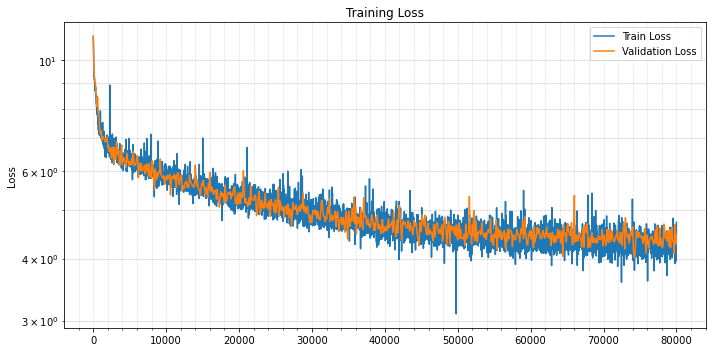

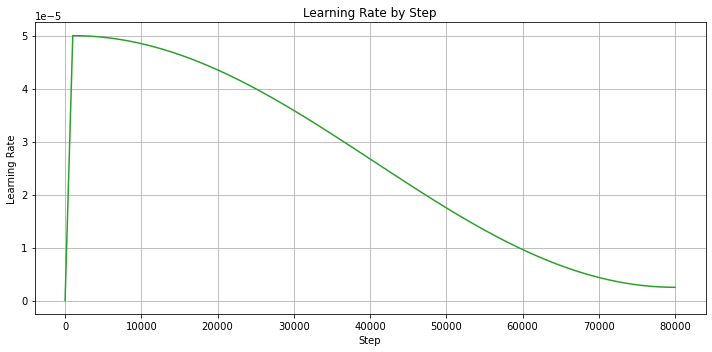

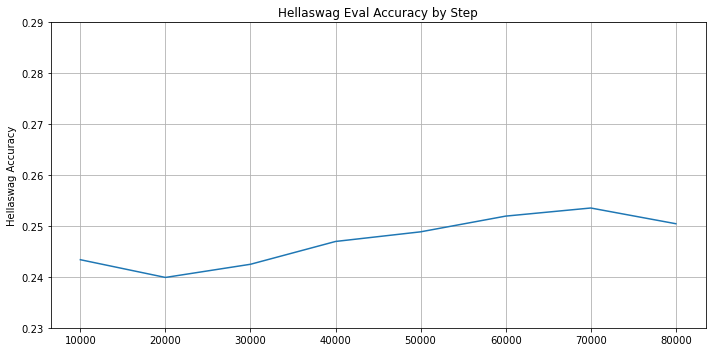

In [56]:
# Training Loss Figure
fig1, ax1 = plt.subplots(figsize=(10, 5), facecolor="white")
ax1.plot(
    df_metrics["step"], df_metrics["train_loss"], color="tab:blue", label="Train Loss"
)
ax1.plot(
    df_metrics["step"][df_metrics["val_loss"].notna()],
    df_metrics["val_loss"][df_metrics["val_loss"].notna()],
    color="tab:orange",
    label="Validation Loss",
    zorder=4,
)
ax1.legend()
ax1.yaxis.grid(True, which="both", linestyle="--", linewidth=0.5)
ax1.xaxis.set_major_locator(mticker.AutoLocator())
ax1.xaxis.set_minor_locator(mticker.AutoMinorLocator())
ax1.xaxis.grid(True, which="both", linestyle=":", linewidth=0.5)
ax1.set_yscale("log")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.grid(True)
fig1.patch.set_facecolor("white")
plt.tight_layout()
plt.show()

# Learning Rate Figure
fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.plot(df_metrics["step"], df_metrics["lr"], color="tab:green")
ax2.set_xlabel("Step")
ax2.set_ylabel("Learning Rate")
ax2.set_title("Learning Rate by Step")
ax2.grid(True)
plt.tight_layout()
plt.show()

# Hellaswag Eval Accuracy Figure
fig3, ax3 = plt.subplots(figsize=(10, 5))
ax3.plot(
    df_metrics["step"][df_metrics["hellaswag_acc"].notna()],
    df_metrics["hellaswag_acc"][df_metrics["hellaswag_acc"].notna()],
    color="tab:blue",
)
ax3.set_ylabel("Hellaswag Accuracy")
ax3.set_title("Hellaswag Eval Accuracy by Step")
ax3.grid(True)
ax3.set_ylim(bottom=0.23, top=0.29)
plt.tight_layout()
plt.show()

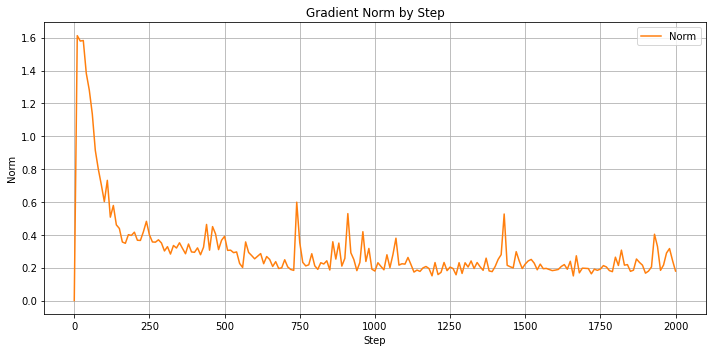

In [48]:
# Plot Norm
fig_norm, ax_norm = plt.subplots(figsize=(10, 5))
ax_norm.plot(df_metrics["step"], df_metrics["norm"], color="tab:orange", label="Norm")
ax_norm.set_xlabel("Step")
ax_norm.set_ylabel("Norm")
ax_norm.set_title("Gradient Norm by Step")
ax_norm.grid(True)
ax_norm.legend()
plt.tight_layout()
plt.show()